<a href="https://colab.research.google.com/github/tanvir-152/Thesis_Codes/blob/main/2DCNN_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#pip install --upgrade pip

In [ ]:
#pip install tensorflow-determinism

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio
import scipy.io as sio
import tensorflow.compat.v1 as v1

# tf.disable_v2_behavior()

In [ ]:
from tf_utils import random_mini_batches_single, convert_to_one_hot
from tensorflow.python.framework import ops


In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [ ]:
def create_placeholders(n_x, n_y):

    isTraining = v1.placeholder_with_default(True, shape=())
    x = v1.placeholder(tf.float32, [None, n_x], name = "x")
    y = v1.placeholder(tf.float32, [None, n_y], name = "Y")

    return x, y, isTraining

In [ ]:
def initialize_parameters():


    v1.set_random_seed(1)

    x_w1 = v1.get_variable("x_w1", [3,3,200,32], initializer =tf.initializers.GlorotUniform (seed = 1))
    x_b1 = v1.get_variable("x_b1", [32], initializer = v1.zeros_initializer())

    x_w2 = v1.get_variable("x_w2", [3,3,32,64], initializer = tf.initializers.GlorotUniform (seed = 1))
    x_b2 = v1.get_variable("x_b2", [64], initializer = v1.zeros_initializer())

    x_w3 = v1.get_variable("x_w3", [1,1,64,128], initializer = tf.initializers.GlorotUniform (seed = 1))
    x_b3 = v1.get_variable("x_b3", [128], initializer = v1.zeros_initializer())

    x_w4 = v1.get_variable("x_w4", [1,1,128,16], initializer = tf.initializers.GlorotUniform (seed = 1))
    x_b4 = v1.get_variable("x_b4", [16], initializer = v1.zeros_initializer())

    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2,
                  "x_w3": x_w3,
                  "x_b3": x_b3,
                  "x_w4": x_w4,
                  "x_b4": x_b4}

    return parameters

In [ ]:
def mynetwork(x, parameters, isTraining, momentums = 0.9):

    x = tf.reshape(x, [-1, 7, 7, 200], name = "x")

    with tf.name_scope("x_layer_1"):

         x_z1 = tf.nn.conv2d(x, parameters['x_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b1']
         x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_z1_po = v1.layers.max_pooling2d(x_z1_bn, 2, 2, padding='SAME')
         x_a1 = tf.nn.relu(x_z1_po)

    with tf.name_scope("x_layer_2"):

         x_z2 = tf.nn.conv2d(x_a1, parameters['x_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b2']
         x_z2_bn = v1.layers.batch_normalization(x_z2, momentum = momentums, training = isTraining)
         x_z2_po = v1.layers.max_pooling2d(x_z2_bn, 2, 2, padding='SAME')
         x_a2 = tf.nn.relu(x_z2_po)

    with tf.name_scope("x_layer_3"):

         x_z3 = tf.nn.conv2d(x_a2, parameters['x_w3'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b3']
         x_z3_bn = v1.layers.batch_normalization(x_z3, momentum = momentums, training = isTraining)
         x_z3_po = v1.layers.max_pooling2d(x_z3_bn, 2, 2, padding='SAME')
         x_a3 = tf.nn.relu(x_z3_po)

    with tf.name_scope("x_layer_4"):

         x_z4 = tf.nn.conv2d(x_a3, parameters['x_w4'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b4']
         x_z4_shape = x_z4.get_shape().as_list()
         x_z4_2d = tf.reshape(x_z4, [-1, x_z4_shape[1] * x_z4_shape[2] * x_z4_shape[3]])


    l2_loss =   tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2']) + tf.nn.l2_loss(parameters['x_w3'])\
                + tf.nn.l2_loss(parameters['x_w4'])

    return x_z4_2d, l2_loss

In [ ]:
def mynetwork_optimaization(y_es, y_re, l2_loss, reg, learning_rate, global_step):

    with tf.name_scope("cost"):

         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_es, labels = y_re)) + reg * l2_loss

    with tf.name_scope("optimization"):
         update_ops = v1.get_collection(v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)
         optimizer = v1.group([optimizer, update_ops])

    return cost, optimizer

In [ ]:
def confusion_mat(x_out, y_in):
  x_cls = tf.transpose(x_out)
  y_cls = tf.transpose(y_in)
  x_cls = tf.argmax(x_out, 1)
  # x_cls = tf.nn.embedding_lookup(np.identity(13), x_cls_)
  # x_cls = convert_to_one_hot(np.array(x_cls)-1, 13)
# TrLabel = TrLabel.T
  y_cls = tf.argmax(y_in, 1)
  confusion = v1.confusion_matrix(y_cls, x_cls, 16)
  return x_cls, y_cls, confusion

In [ ]:
def train_mynetwork(x_train_set, y_train_set, x_test_set, y_test_set, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()
    v1.set_random_seed(1)
    seed = 1
    (m, n_x) = x_train_set.shape
    (m, n_y) = y_train_set.shape

    costs = []
    costs_dev = []
    train_acc = []
    val_acc = []
    correct_prediction = 0

    # Create Placeholders of shape (n_x, n_y)
    x, y, isTraining = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()

    with tf.name_scope("network"):

         x_out, l2_loss= mynetwork(x, parameters, isTraining)

    global_step = tf.Variable(0, trainable = False)
    learning_rate = v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)

    with tf.name_scope("optimization"):
         # network optimization
         cost, optimizer = mynetwork_optimaization(x_out, y, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         # Calculate the correct predictions
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    with tf.name_scope("con"):
         x_cls, y_cls, confusion = confusion_mat(x_out,y)

    # Initialize all the variables
    init = v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with v1.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_single(x_train_set, y_train_set, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_x, y: batch_y, isTraining: True})

                epoch_cost += minibatch_cost
                epoch_acc += minibatch_acc

            epoch_cost_train = epoch_cost / num_minibatches
            epoch_acc_train = epoch_acc / num_minibatches

            features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x: x_test_set, y: y_test_set, isTraining: False})

            # Print the cost every epoch
            if print_cost == True and (epoch) % 50 == 0:
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost_train, epoch_cost_dev, epoch_acc_train, epoch_acc_dev))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost_train)
                train_acc.append(epoch_acc_train)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)

            if print_cost == True and epoch == 200:
                # con_mat =
                x, y, confusion = sess.run([x_cls, y_cls, confusion], feed_dict={x: x_test_set, y: y_test_set, isTraining: False})
                # print(x.shape)
                # print(y.shape)
                # print(confusion)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        return parameters, val_acc, features

In [ ]:
X_train = scio.loadmat('HSI_CNN/X_train.mat')
Y_train = scio.loadmat('HSI_CNN/Y_train.mat')

In [ ]:
X_test = scio.loadmat('HSI_CNN/X_test.mat')
Y_test = scio.loadmat('HSI_CNN/Y_test.mat')

In [ ]:
X_train = X_train['X_train']
Y_train = Y_train['Y_train']
X_test = X_test['X_test']
Y_test = Y_test['Y_test']

In [ ]:
Y_train = convert_to_one_hot(Y_train-1, 16)
Y_test = convert_to_one_hot(Y_test-1, 16)

In [ ]:
Y_train = Y_train.T
Y_test = Y_test.T

In [ ]:
v1.disable_eager_execution()

<ipython-input-9-e9cd77b82606>:8: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
Instructions for updating:
Colocations handled automatically by placer.
<ipython-input-9-e9cd77b82606>:9: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  x_z1_po = v1.layers.max_pooling2d(x_z1_bn, 2, 2, padding='SAME')
<ipython-input-9-e9cd77b82606>:15: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UP

epoch 0: Train_loss: 2.133400, Val_loss: 2.514567, Train_acc: 0.343750, Val_acc: 0.118705
epoch 50: Train_loss: 0.131607, Val_loss: 1.130743, Train_acc: 0.998512, Val_acc: 0.701685
epoch 100: Train_loss: 0.097235, Val_loss: 0.934562, Train_acc: 1.000000, Val_acc: 0.770655
epoch 150: Train_loss: 0.083692, Val_loss: 0.960262, Train_acc: 1.000000, Val_acc: 0.765278
epoch 200: Train_loss: 0.073837, Val_loss: 0.975975, Train_acc: 1.000000, Val_acc: 0.764140


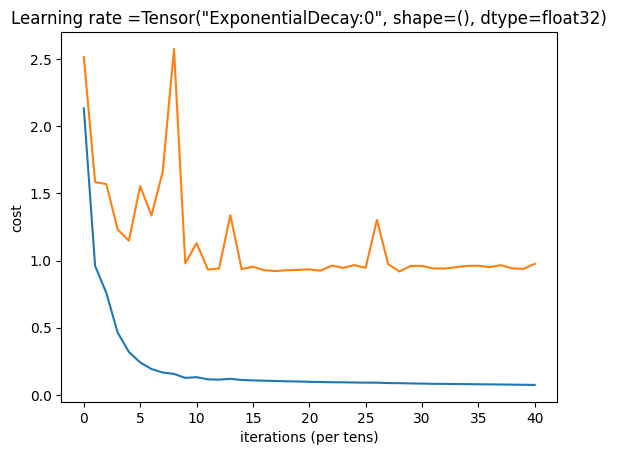

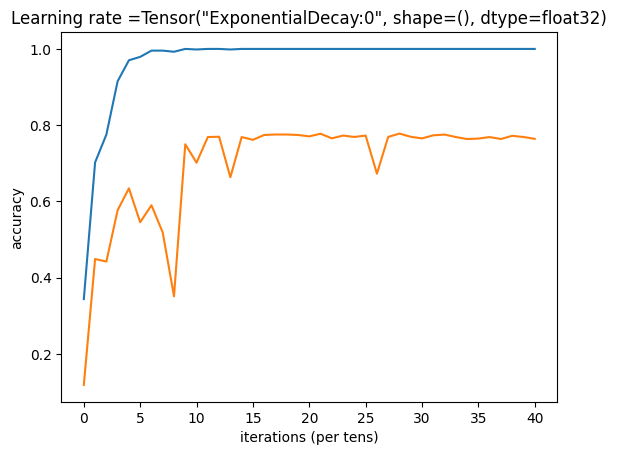

Parameters have been trained!


In [ ]:
parameters, val_acc, features = train_mynetwork(X_train, Y_train, X_test, Y_test)
sio.savemat('features.mat', {'features': features})